In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline
plt.ion()

import os
import sys
import re
import pdb
import glob

sys.path.insert(0, '/Users/jkinney/github/anylogo/')
sys.path.append('../src')
#sys.path.append('/Users/jkinney/github/anylogo')
import utils
from anylogo import logomaker
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
# Load ratios
in_file = '../output/ratios_9nt_ss_locus.txt'
df = pd.read_csv(in_file,sep='\t')
df.set_index('ss',inplace=True,drop=True)
site_length = len(df.index[0])    

In [3]:
# Normalize each column by consens sequence value
cons_seq = 'CAGGUAAGU'
for col in df.columns:
    df.loc[:,col] = 100*df.loc[:,col]/df.loc[cons_seq,col]

In [9]:
# Compute feature vectors for each single position
bases = 'ACGU'
variable_positions = [0,1,2,5,6,7,8]

char_df = pd.DataFrame(index=df.index)
#char_df.loc[:,'const'] = 1.0
for i in variable_positions:
    for b in bases:
        col_name = '%d%s'%(i,b)
        char_df.loc[:,col_name] = [float(ss[i]==b) for ss in df.index]

print len(char_df)
char_df.head()

32768


,0A,0C,0G,0U,1A,1C,1G,1U,2A,2C,...,6G,6U,7A,7C,7G,7U,8A,8C,8G,8U
ss,,,,,,,,,,,,,,,,,,,,,
AAAGCAAAA,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAAGCAAAC,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AAAGCAAAG,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
AAAGCAAAU,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
AAAGCAACA,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [13]:
# Drop nan rows
measurements = df['brca2_9nt'].dropna()

# Keep only GU splice sites
indices = [ss[3:5]=='GU' for ss in measurements.index]
measurements = measurements[indices]

# Filter for substantial values
splicing_threshod = 0
measurements = measurements[measurements >= splicing_threshod]
len(measurements)

X = char_df.loc[measurements.index,:]
len(X)

16216

In [14]:
# Do linear regression with small rige penalty to fix gauge

from sklearn import linear_model
reg = linear_model.Ridge (alpha = .0001)
reg.fit (X.values, measurements.values)

Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

          A         C          G         U
0  1.022206  2.601940  -1.630298 -1.993848
1  4.250776  0.085220  -1.561616 -2.774379
2 -4.228451 -3.978427  12.559729 -4.352854
5  9.740258 -4.730463  -0.653131 -4.356664
6  5.616935 -1.295270  -2.467000 -1.854665
7 -2.532181 -3.108604   8.225124 -2.584339
8 -1.343269 -1.294832  -0.479795  3.117895


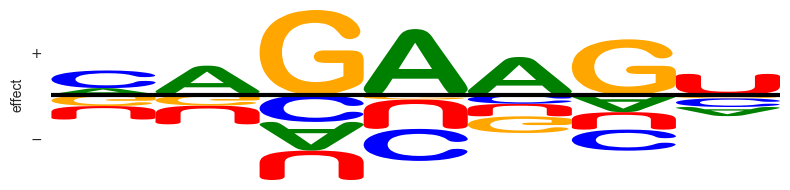

In [15]:
logo_matrix = pd.DataFrame(index=variable_positions,columns=list(bases))
logo_matrix.loc[:,:] = reg.coef_.reshape(7,4)
print logo_matrix
logo = logomaker.make_logo(matrix=logo_matrix, 
                           matrix_type='enrichment', 
                           logo_type='enrichment', 
                           counts_threshold=0, 
                           colors='classic',
                           ylabel='effect', 
                           font_family='Arial Rounded MT Bold',
                           axes_type='naked',
                           baseline_alpha=1,
                           baseline_color='black',
                           baseline_width=3,
                           show_baseline=True,
                           show_binary_yaxis=True)

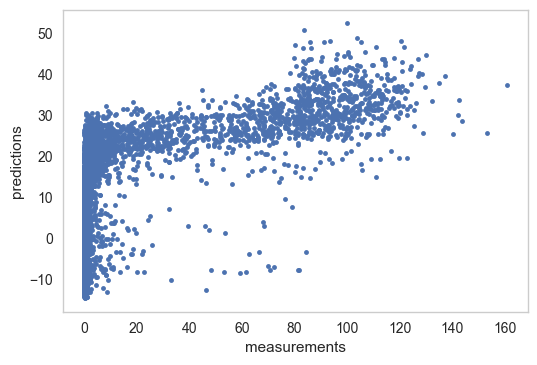

In [20]:
plt.plot(measurements, reg.predict(X), '.')
plt.xlabel('measurements')
plt.ylabel('predictions')

In [16]:
# # Do regression
# from numpy.linalg import lstsq

# coeffs,x,xx,xxx = lstsq(X.values,measurements.values)
# coeffs

In [17]:
# # Subtract out mean element at each position
# P = pd.DataFrame(columns=X.columns, index=X.columns).fillna(0)
# P.loc['const',:] = 1/4
# P.loc['const','const'] = 1
# x = np.sqrt(3/4)
# for i in variable_positions:
#     for b in bases:
#         row = '%d%s'%(i,b)
#         pos_cols = ['%d%s'%(i,c) for c in bases]
#         P.loc[row,pos_cols] = -x/3
#         P.loc[row,row] = x
# P

In [18]:
# fixed_coeffs = np.mat(P.values)*np.mat(coeffs).T
# fixed_coeffs

In [ ]:
# predictions = np.mat(X.values)*(np.mat(coeffs).T)
# predictions.shape